In [47]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs
import pandas as pd
import gffutils
import os
import yaml
import random   
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import logomaker

In [48]:
class GenomeManager:
    def __init__(self, base_path: str, genome_id: str):
        """
        base_path: root directory containing all genome subfolders (e.g. "data/ncbi_dataset/data")
        genome_id: name of the genome folder (e.g. "GCA_900636475.1")
        """
        self.genome_dir = os.path.join(base_path, genome_id)
        self.fna_path = None
        self.gtf_path = None
        self.gbff_path = None
        self.gff_path = None
        self._find_files()

    def _find_files(self):
        """Scan the genome directory and assign file paths for .fna, .gtf, .gbff, .gff"""
        for fname in os.listdir(self.genome_dir):
            lower = fname.lower()
            full = os.path.join(self.genome_dir, fname)
            if lower.endswith(".fna") or lower.endswith(".fa") or lower.endswith(".fasta"):
                self.fna_path = full
            elif lower.endswith(".gtf"):
                self.gtf_path = full
            elif lower.endswith(".gbff") or lower.endswith(".gbk") or lower.endswith(".gbff"):
                self.gbff_path = full
            elif lower.endswith(".gff") or lower.endswith(".gff3"):
                self.gff_path = full

    def summary(self):
        """Print what files are detected in this genome folder."""
        print(f"Genome directory: {self.genome_dir}")
        print(f"  FASTA (.fna): {self.fna_path}")
        print(f"  GTF (.gtf):   {self.gtf_path}")
        print(f"  GBFF (.gbff): {self.gbff_path}")
        print(f"  GFF (.gff/.gff3): {self.gff_path}")

    def read_fna(self, sequence_itself: bool = True):
        """Read the FASTA (.fna) file, return list of SeqRecord objects."""
        if not self.fna_path:
            raise FileNotFoundError("No .fna file found in genome directory.")
        genome = list(SeqIO.parse(self.fna_path, "fasta"))

        if not len(genome) == 1:
            raise ValueError(f"Expected 1 sequence in .fna file, found {len(genome)}")

        seq = genome[0]
        
        if sequence_itself: return seq.seq
        else: return seq

    def load_gff_from_gffutils(self):
        """Load GFF file using gffutils."""
        if not self.gff_path:
            raise FileNotFoundError("No .gff file found in genome directory.")
        # Implement GFF parsing logic here
        
        gff_db = gffutils.create.create_db(data=self.gff_path, dbfn=':memory:', force=True)
        return gff_db
    
    def load_gff(self):
        """Load GFF file using gffutils."""
        if not self.gff_path:
            raise FileNotFoundError("No .gff file found in genome directory.")
        # Implement GFF parsing logic here
        
        # Use read_csv with comment="#" so lines starting with “#” are ignored
        gff_db = pd.read_csv(self.gff_path, sep="\t", comment="#", header=None,
            names=["seqid", "source", "feature", "start", "end", "score", "strand", "phase", "attributes"],
            dtype={
                "seqid": str,
                "source": str,
                "feature": str,
                "start": int,
                "end": int,
                "score": str,    # may be “.” or numeric
                "strand": str,
                "phase": str,
                "attributes": str
            },
            # In case there are “bad lines” (e.g. wrong number of columns), skip them
            on_bad_lines="skip"
        )

        return gff_db
    
    def extract_promoter_regions(self, find_method: str = "random", n: int = 100, upstream_start: int = 15, upstream_end: int = 5):
        """Extract promoter regions from fasta file based on GFF annotations."""

        if find_method not in ["random", "first"]:
            raise ValueError(f"Unknown find_method: {find_method}")

        gff_db = self.load_gff()
        genome_seq = self.read_fna(sequence_itself=True)

        # Filter for gene features
        genes = gff_db[gff_db['feature'] == 'gene']
        if genes.empty:
            raise ValueError("No gene features found in GFF file.")
        elif len(genes) < n:
            raise ValueError(f"Requested {n} genes, but only found {len(genes)} in GFF file.")
        
        if find_method == "random":
            sampled_genes = genes.sample(n=n, random_state=2024)  # For reproducibility
        elif find_method == "first":
            sampled_genes = genes.head(n)

        upstream_regions = []

        for _, row in sampled_genes.iterrows():
            start = row['start'] - 1  # Convert to 0-based index
            end = row['end']          # End is inclusive in GFF but this is 1-based
            strand = row['strand']
            
            if strand == '+':
                region_start = max(0, start - upstream_start)
                region_end = max(0, start - upstream_end)
                seq = genome_seq[region_start:region_end+1]
            elif strand == '-':
                region_start = end + upstream_end
                region_end = end + upstream_start
                seq = genome_seq[region_start:region_end+1].reverse_complement()
            else:
                continue  # Skip if strand information is invalid

            upstream_regions.append(seq)

        return upstream_regions

## 1. Construct the Position Probbility Matrix (PPM) 

Loading genomes

In [49]:
# Load YAML file and read data paths
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

data_path = config['data_path']
ref_genome = config['ref_genome']

#Loading reference genome
ref_genome_path = os.path.join(data_path, ref_genome)
print(f"Reference genome path: {ref_genome_path}")
ref_genome = GenomeManager(config['data_path'], config['ref_genome'])

# Load genome files from data path
ref_sequence = ref_genome.read_fna(sequence_itself=True)
gff_database = ref_genome.load_gff()
ref_sequence

Reference genome path: data/ncbi_dataset/data\GCA_900636475.1


Seq('GAATTATCGGAGGAGCGACTTGGCGACAAGTTGTGATGGTGGTAGGAATTGTTT...AGG')

Locating 1100 genes of the organism that have been predicted based upon homology and select 100 genes to construct the PPM. 

In [50]:
def has_WWWWWW(region):
    """Check if there's at least form 'WWWWWW' in the region."""
    region = str(region)
    W6_RE = re.compile(r'(?:A|T){6}', flags=re.IGNORECASE)
    if W6_RE.search(region):
        return True
    return False

In [51]:
random.seed(0)  # For reproducibility

N = 1100
regions = ref_genome.extract_promoter_regions(find_method="random", n=N)
print(f"Extracted {len(regions)} promoter regions.")
all_idx = set(range(len(regions)))

# Filter regions that have 'WWWWWW' in their sequence
# feasible_idx = [i for i, region in enumerate(regions) if has_WWWWWW(region)]
# print(f"Number of regions with 'WWWWWW' in promoter sequence: {len(feasible_idx)}")

# Sample 100 regions for PPM construction
ppm_idx = random.sample(list(all_idx), 100)
#ppm_idx = random.sample(feasible_idx, 100)
regions_ppm = [regions[i] for i in ppm_idx]

non_ppm_idx = list(all_idx - set(ppm_idx))
regions_non_ppm = [regions[i] for i in non_ppm_idx]
    
print(f"Selected {len(regions_ppm)} regions for PPM construction.")
print(len(regions_ppm[0]))

Extracted 1100 promoter regions.
Selected 100 regions for PPM construction.
11


Promoter finder Algorithm

In [52]:
def find_promoter(region, promoter_template: str = "WAWWWT"):
    
    region_len = len(region)
    promoter_len = 6
    region = str(region)

    # 'W' means 'A' or 'T'
    mapping = {
        'W': ['A', 'T'],    
        'A': ['A'],
        'T': ['T']
    }
    #print("Searching in region:", region)

    for i in range(region_len - promoter_len, -1, -1):
        segment = region[i:i+promoter_len]
        #print("Segment:", segment)
        match = True
        for j in range(promoter_len):
            if segment[j] not in mapping[promoter_template[j]]:
                match = False
                break
        if match:
        #     print("Found promoter at position", i, ":", segment)
            return region[i:i+promoter_len]
    return None

promoters = []
for region in regions_ppm:
    promoter = find_promoter(region)
    if promoter:
        promoters.append(promoter)

print(f"Found {len(promoters)} promoters out of {len(regions_ppm)} regions.")
print(promoters)

Found 6 promoters out of 100 regions.
['TATAAT', 'TATATT', 'TATTTT', 'TATAAT', 'TAAAAT', 'AATATT']


Construct PPM Matrix

In [53]:
m = motifs.create(promoters, alphabet="ACGT")
ppm = m.counts.normalize(pseudocounts=0.15)
print("Position Probability Matrix:")
print(ppm)
print(f"Consensus promoter: {m.consensus}")

Position Probability Matrix:
        0      1      2      3      4      5
A:   0.17   0.93   0.17   0.78   0.48   0.02
C:   0.02   0.02   0.02   0.02   0.02   0.02
G:   0.02   0.02   0.02   0.02   0.02   0.02
T:   0.78   0.02   0.78   0.17   0.48   0.93

Consensus promoter: TATAAT


<Figure size 800x300 with 0 Axes>

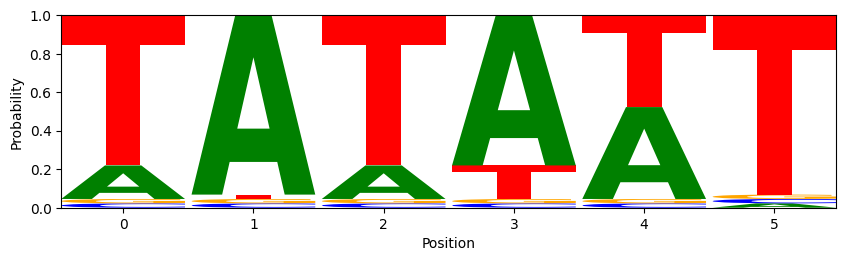

In [54]:
bases = ['A','C','G','T']
df = pd.DataFrame(ppm, columns=bases)

plt.figure(figsize=(8,3))
logomaker.Logo(df, color_scheme='classic')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.show()

In [55]:
from Bio import motifs
from Bio.Seq import Seq

# Example promoter sequences
promoters = [Seq("TATAAT"), Seq("TATATT"), Seq("TATTTA"), Seq("AATATT"), Seq("TAAAAA"), Seq("TATAAT")]

# Create motif
m = motifs.create(promoters, alphabet="ACGT")

# Save weblogo image (requires WebLogo package)
m.weblogo("predicted_motif_logo.png", format="png", show_fineprint=False)


## 2. Statistical Alignment for remaining 1000 regions

Calculating alignment scores for a region

In [56]:
def alignment_score(ppm, sequence, promoter_len: int = 6):
    
    sequence = str(sequence)
    seq_len = len(sequence)
    max_score = float('-inf')

    for i in range(seq_len - promoter_len + 1):
        segment = sequence[i:i+promoter_len]
        score = 1
        for j in range(promoter_len):
            nucleotide = segment[j]
            if nucleotide in ppm:
                score *= ppm[nucleotide][j]
            else:
                score *= 0.0

        # get the natural log of the score to avoid underflow
        log_score = math.log(score) if score > 0 else float('-inf')
        if log_score > max_score:
            max_score = log_score

    return max_score

Statistical alignment for residual 1000 regions.

In [57]:
consensus_promoter = str(m.consensus)
consensus_score = alignment_score(ppm, consensus_promoter)
print(f"Alignment score for consensus promoter ({consensus_promoter}): {consensus_score}")
threshold_score = 1.8

regions_1000 = regions_non_ppm

ref_promoter_hits = []
ref_alignment_scores = []

for region in regions_1000:
    score = alignment_score(ppm, region)
    ref_alignment_scores.append(score)
    if score - consensus_score >= -threshold_score:
        ref_promoter_hits.append(region)

print("Alignment scores for 1000 regions:")
print(len(sorted(ref_promoter_hits, reverse=True)))

Alignment score for consensus promoter (TATAAT): -1.6251211336929503
Alignment scores for 1000 regions:
29


Visualizing alignment score distribution

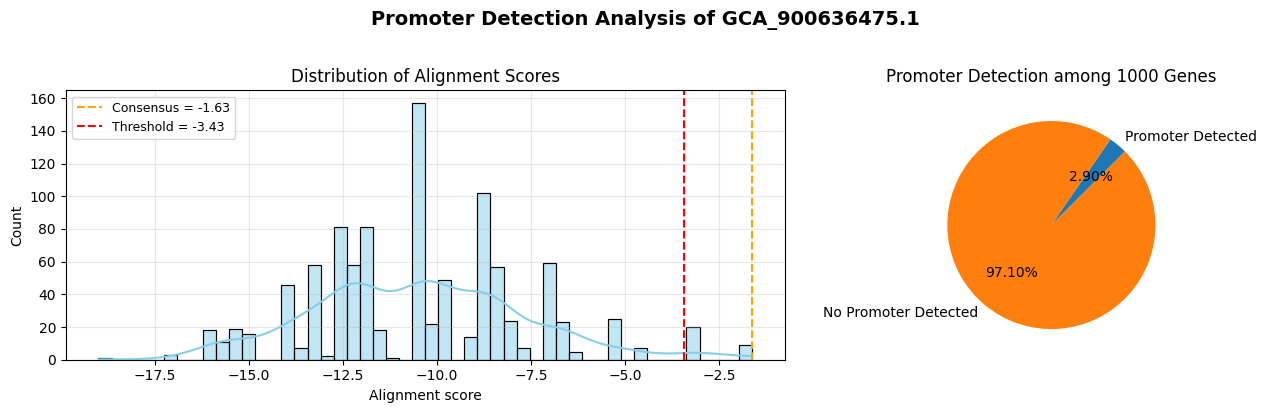

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import gridspec

fig = plt.figure(figsize=(13, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])
axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]

# ---- Left subplot ----
sns.histplot(ref_alignment_scores, bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].axvline(x=consensus_score, color='orange', linestyle='--', label=f'Consensus = {consensus_score:.2f}')
thr_line = consensus_score - threshold_score
axes[0].axvline(x=thr_line, color='red', linestyle='--', label=f'Threshold = {thr_line:.2f}')
axes[0].set_title('Distribution of Alignment Scores', fontsize=12)
axes[0].set_xlabel('Alignment score')
axes[0].set_ylabel('Count')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# ---- Right subplot ----
labels = ['Promoter Detected', 'No Promoter Detected']
sizes = [len(ref_promoter_hits), 1000 - len(ref_promoter_hits)]

axes[1].pie(
    sizes,
    labels=labels,
    autopct='%1.2f%%',
    startangle=45,
    textprops={'fontsize': 10},
    colors=['#1f77b4', '#ff7f0e']
)
axes[1].set_title('Promoter Detection among 1000 Genes', fontsize=12)
axes[1].axis('equal')

ref_genome_name = config['ref_genome']
# ---- Add overall figure title ----
fig.suptitle(
    f'Promoter Detection Analysis of {ref_genome_name}',
    fontsize=14,
    fontweight='bold',
    y=1.02  # move title slightly above the plots
)

plt.tight_layout()
plt.show()


## 3. Searching the promoters in other Genomes from the PPM of 1


Processing genome: GCA_001457635.1
Number of promoter hits in GCA_001457635.1: 36


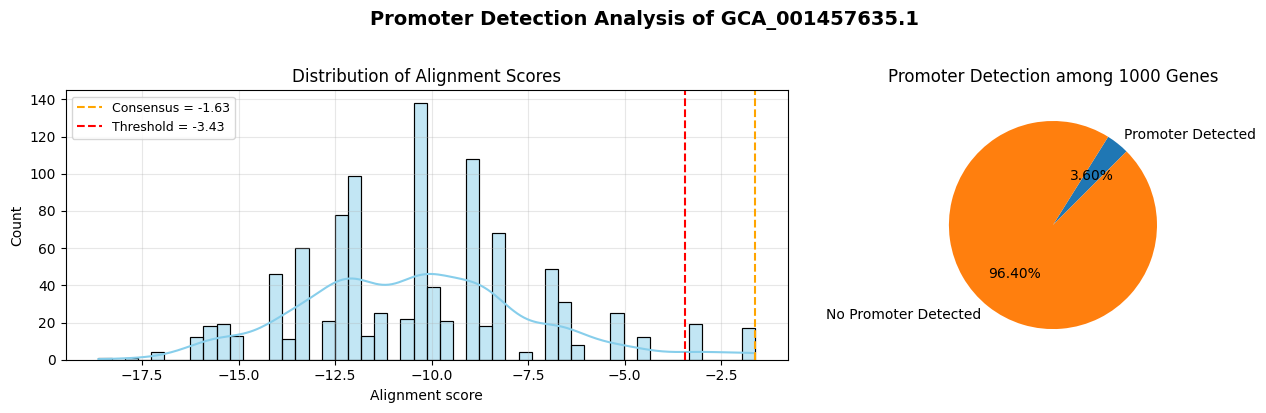


Processing genome: GCA_019046945.1
Number of promoter hits in GCA_019046945.1: 44


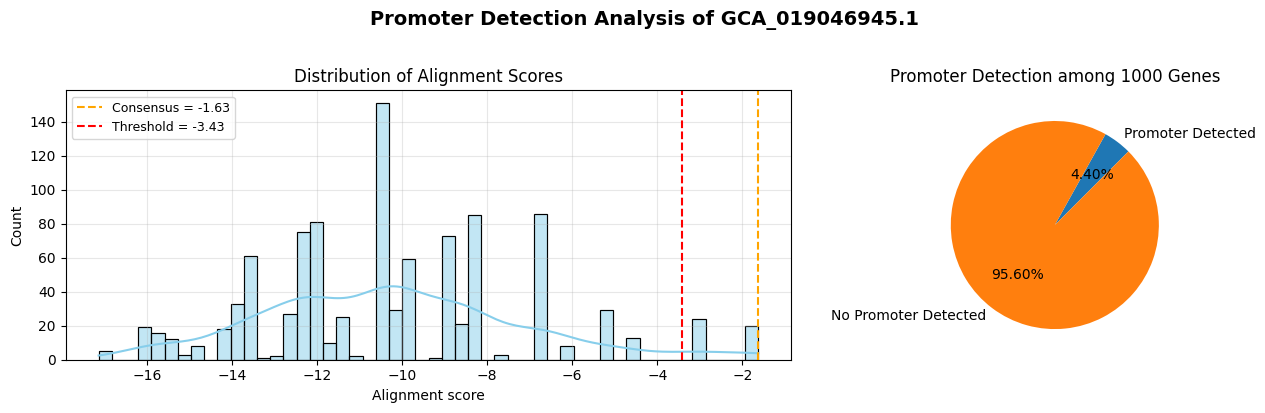


Processing genome: GCA_019048645.1
Number of promoter hits in GCA_019048645.1: 44


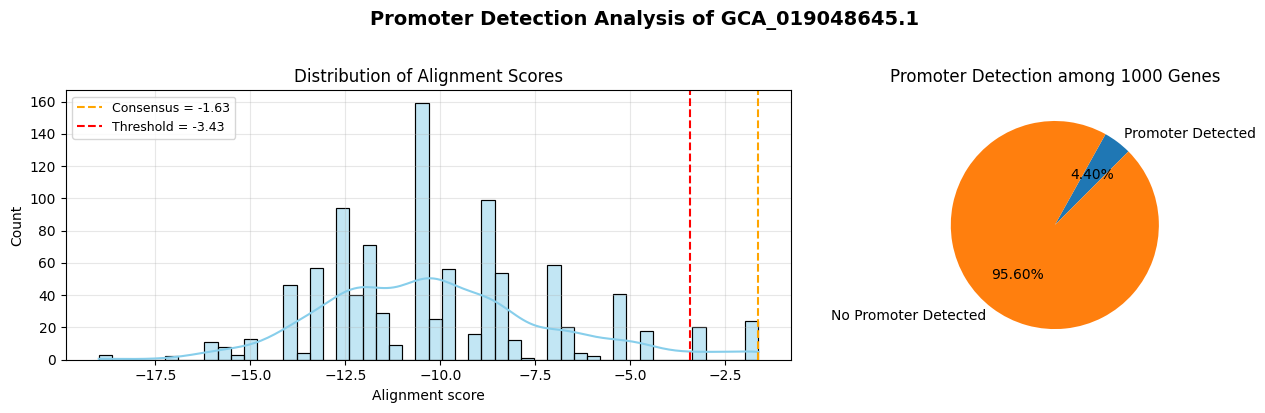


Processing genome: GCA_900475505.1
Number of promoter hits in GCA_900475505.1: 20


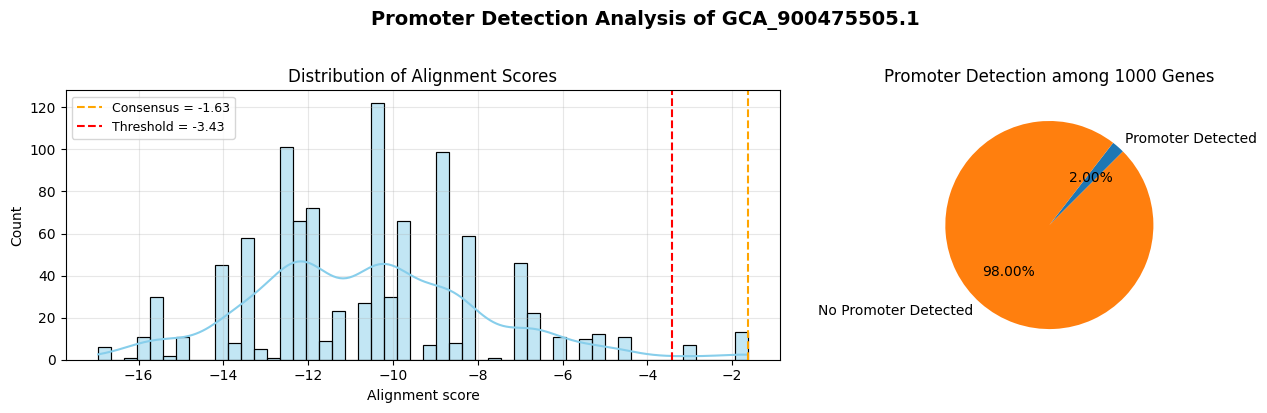


Processing genome: GCA_900637025.1
Number of promoter hits in GCA_900637025.1: 30


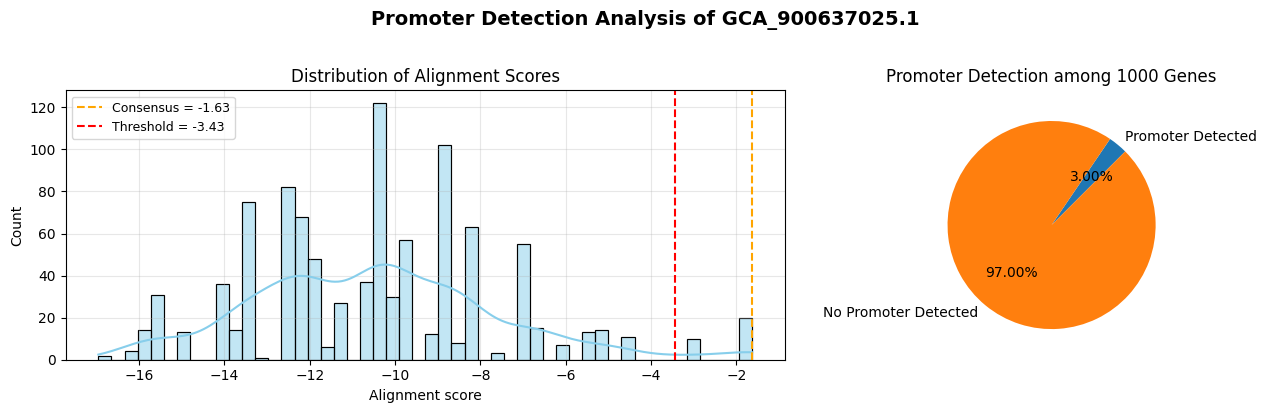

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import gridspec
import os

# Load genome directories (excluding reference)
genomes = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
genomes = [g for g in genomes if g != ref_genome.genome_dir.split(os.sep)[-1]]

# Reference data for alignment
ref_consensus_score = consensus_score
ref_ppm = ppm
threshold_score = 1.8

# --- Loop through each genome ---
for g in genomes:
    print(f"\nProcessing genome: {g}")
    genome = GenomeManager(data_path, g)
    regions = genome.extract_promoter_regions(find_method="random", n=1000)

    alignment_scores = []
    promoter_hits = []

    # Calculate alignment scores and find promoter hits
    for region in regions:
        score = alignment_score(ref_ppm, region)
        alignment_scores.append(score)
        if score - ref_consensus_score >= -threshold_score:
            promoter_hits.append(region)

    print(f"Number of promoter hits in {g}: {len(promoter_hits)}")

    # --- Visualization Section ---
    fig = plt.figure(figsize=(13, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])
    axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]

    # ---- Left subplot: histogram ----
    sns.histplot(alignment_scores, bins=50, kde=True, color='skyblue', ax=axes[0])
    axes[0].axvline(x=ref_consensus_score, color='orange', linestyle='--', label=f'Consensus = {ref_consensus_score:.2f}')
    thr_line = ref_consensus_score - threshold_score
    axes[0].axvline(x=thr_line, color='red', linestyle='--', label=f'Threshold = {thr_line:.2f}')
    axes[0].set_title('Distribution of Alignment Scores', fontsize=12)
    axes[0].set_xlabel('Alignment score')
    axes[0].set_ylabel('Count')
    axes[0].legend(fontsize=9)
    axes[0].grid(alpha=0.3)

    # ---- Right subplot: pie chart ----
    labels = ['Promoter Detected', 'No Promoter Detected']
    sizes = [len(promoter_hits), len(regions) - len(promoter_hits)]

    axes[1].pie(
        sizes,
        labels=labels,
        autopct='%1.2f%%',
        startangle=45,
        textprops={'fontsize': 10},
        colors=['#1f77b4', '#ff7f0e']
    )
    axes[1].set_title('Promoter Detection among 1000 Genes', fontsize=12)
    axes[1].axis('equal')

    # ---- Add genome-specific title ----
    fig.suptitle(
        f'Promoter Detection Analysis of {g}',
        fontsize=14,
        fontweight='bold',
        y=1.02
    )

    plt.tight_layout()
    plt.show()
